In [1]:
import sys, time, os
from pathlib import Path
import imageio
import numpy as np
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt 
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from landlab import (RasterModelGrid, imshow_grid, imshowhs_grid)
from landlab.plot import graph
from landlab.graph import NetworkGraph
from landlab.grid.network import NetworkModelGrid
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler,
                                PriorityFloodFlowRouter,
                                BedrockLandslider,
                                FireGenerator)
from landlab.utils import get_watershed_mask
from landlab.io import read_esri_ascii, write_esri_ascii
from bmi_topography import Topography

%matplotlib inline

# Here figures are made larger and matplotlib warnings are suppressed for presentation purposes
plt.rcParams['figure.figsize'] = [10, 10] 
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from IPython.display import clear_output

# Modules are autoreloaded for easy modification
%load_ext autoreload
%autoreload 2

In [2]:
# here are the new functionalities to implement randomly burned areas....

import numpy as np

class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  -(space.K_sed-self.K_sed0)*dt/self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire_mean=1, K_sed_boost=1, dt = 1,dx=1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire_mean = R_fire_mean # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        self.fireTimes=[] # empty list to be filled with the times when fires happened
        self.fireSizes=[] # empty list to be filled with the sizes of fires that happened
        self.dx=dx # size of the grid used by space
        
    @property
    def R_fire(self):
        """
        choose a random fire size from an exponential distribution
        having mean size R_fire_mean
        """
        return np.random.exponential(self.R_fire_mean) # exponential random var
        
        
    def fire(self, space, grid, t):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if..
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(-self.dt*self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs: # if fire does not occur...
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            changed_nodes = self._within(center, space , grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes]+= self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center

            # just a print block to explain what's happening...
            s1 = grid.x_of_node[center]
            s2 = grid.y_of_node[center]
            A = len(changed_nodes)*self.dx**2/1e6 # area of the fire if it occcurred
            # units of A are km^2. 
            print(r'fire at ({},{}) of area {} square km.'.format(s1,s2,round(A,2)))
            
            
            # save the time and magnitude of the fire
            self.fireTimes.append(t) # time at which the fire happened
            self.fireSizes.append(A) # area of the fire which happened.
                        
        
    def _within(self,center, space, grid):
        """
        return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < self.R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire

In [3]:
def create_network_from_raster(
        rmg, min_channel_thresh=10000, outlet_nodes=None, method='variable',
        n_widths=20, a=9.68, b=0.32, d_node_spacing=None, fields=None):
    """Create a NetworkModelGrid from a RasterModelGrid. Default behavior
    spaces nodes a certain number of local channel widths apart across the
    network. If method='constant' is specified, the d_node_spacing value
    is used to space nodes a constant distance apart across the network.
    Parameters
    ----------
    rmg : RasterModelGrid object
        A raster grid used to create a network grid
    min_channel_thresh : float, optional
        Value to use for the minimum drainage area associated with a
        plotted channel segment from the ChannelProfiler. Default values 10000.
    outlet_nodes : Single int value in iterable form, optional
        Iterable containing the node ID of nodes to start the channel profiles
        from in ChannelProfiler. If not provided, the default is the node ID on
        the model grid boundary with the largest terminal drainage area.
    method : string, 'variable' or 'constant'
        Specifies node-spacing method. 'variable' will dynamically update
        node spacing depending on local channel width. 'constant' will use the
        specified 'node_spacing' value to space nodes evenly across the
        network.
    n_widths : float, optional
        Multiplier to define node spacing as a function of local channel width.
    a : float, optional
        Parameter to be used in the Frasson et al. 2019 (GRL) power
        relationship between drainage area and channel width W=a*A^b. Default
        is value is 9.68 from Frassen et. al 2019
    b : float, optional
        Parameter to be used in the Frasson et al. 2019 (GRL) power
        relationship between drainage area and channel width W=a*A^b. Default
        is value is 0.32 from Frassen et. al 2019
    d_node_spacing : float, optional
        Distance value for a constant node spacing along channel segments.
        Must be provided if method is 'constant'.
    fields : iterable, optional
        .at_node fields to map from RasterModelGrid to NetworkModelGrid.
        Formatted as strings inside an iterable object
    Returns
    -------
    NetworkModelGrid object with .at_node['rmg_node_value'] attribute
    listing the RasterModelGrid node ids at each NetworkModelGrid node.
    """

    if 'drainage_area' not in rmg.at_node:
        # run flow accumulator for ChannelProfiler
        fa = FlowAccumulator(rmg,
                             'topographic__elevation',
                             flow_director='D8',
                             depression_finder='DepressionFinderAndRouter')
        fa.run_one_step()

    # delinate channel
    profiler = ChannelProfiler(
        rmg,
        number_of_watersheds=1,
        minimum_channel_threshold=min_channel_thresh,
        outlet_nodes=outlet_nodes,
        main_channel_only=False,
    )
    profiler.run_one_step()

    # obtain watershed key (should only be one)
    wtrshd_key = [k for k in profiler.data_structure.keys()][0]
    # obtain keys for channel segments, keys are raster nodes formated as
    # tuple for (start, end) for channel segment start and end locations
    channel_segment_keys = profiler.data_structure[wtrshd_key].keys()

    # IDENTIFY CHANNEL SEGMENT CONNECTIVITY -----------------------------------
    # obtain node ids for start and end of every channel segments
    seg_starts = [seg[0] for seg in profiler.data_structure[wtrshd_key].keys()]
    seg_ends = [seg[1] for seg in profiler.data_structure[wtrshd_key].keys()]
    # identify channel connectivity and how to properly link nodes
    # at different channel junctions
    # code currently identifies the key of the channel seg just downstream
    # and connects first node of upstream channel to downstream channel
    for i, seg_key in enumerate(channel_segment_keys):
        connectivity = []
        connectivity_key = None
        seg_i = profiler.data_structure[wtrshd_key][seg_key]
        # if the start of a segment is the end of another segment
        if seg_key[0] in seg_ends:
            connectivity.append('connected downstream')
            # find first segment downstream that should connect to last node of
            connect_to_channel_idx = np.argmax(seg_key[0] == seg_ends)
            connectivity_key = (seg_starts[connect_to_channel_idx],
                                seg_ends[connect_to_channel_idx])
        # if end of segment is in start of another segment
        if seg_key[-1] in seg_starts:
            connectivity.append('connected upstream')

        seg_i['connectivity'] = connectivity
        seg_i['connectivity_key'] = connectivity_key

    node_xy = []  # empty list to store paired x,y locations of nmg nodes
    rmg_nodes = []  # empty list to store raster model grid node corresponding to each network model grid node
    links = []  # empty list to store link connections between nodes

    # FUNCTION TO ADD LINKS----------------------------------------------------
    # this is called several times in loop below, and makes testing easier
    def add_link(rmg, all_nodes_xy, all_links, head_node_rmg_id,
                 tail_node_rmg_id):

        """Add link connections to existing list of NetworkModelGrid nodes
        based upon an upstream and downstream RasterModelGrid node id. Also
        checks whether (x, y) values for upstream and downstream nodes exist
        in list of node locations and adds them if necessary.
        Parameters
        ----------
        rmg : RasterModelGrid object
            The RasterModelGrid to which NetworkModelGrid nodes and links will
            be added.
        all_nodes_xy : list of tuples
            List where tuple values for node x and y locations formatted as
            [(x1,y1), (x2,y2)...] already exist or will be stored.
        all_links : list of tuples
            List where tuple values for NetworkModelGrid node ids of upstream
            and downstream nodes for each link already exists or will be
            stored. Formatted as [(id2, id1),(id3, id2)...] where id# '#'
            corresponds to the index of the node entry in all_nodes_xy.
        head_node_rmg_id : int
            Value of the RasterModelGrid node id that corresponds to the
            desired head node of a NetworkModelGrid link.
        tail_node_rmg_id : int
            Value of the RasterModelGrid node id that corresponds to the
            desired head node of a NetworkModelGrid link.
        Returns
        -------
        None.
        """
        # define head node xy value by calling id from raster model grid
        head_node_xy = (rmg.x_of_node[head_node_rmg_id],
                        rmg.y_of_node[head_node_rmg_id])
        # define a tail node xy value by calling id from raster model grid
        tail_node_xy = (rmg.x_of_node[tail_node_rmg_id],
                        rmg.y_of_node[tail_node_rmg_id])
        # if these nodes don't already exist in the array of node xy vals from
        # another channel segment, add them
        if head_node_xy not in all_nodes_xy:
            all_nodes_xy.append(head_node_xy)
        if tail_node_xy not in all_nodes_xy:
            all_nodes_xy.append(tail_node_xy)
        # get the index of the head and tail node from our node_xy list
        # this is important to do in case they were added from a previous
        # channel segment. we need to ensure the order of network nodes is
        # correct
        head_node__nmg_id = all_nodes_xy.index(head_node_xy)
        tail_node__nmg_id = all_nodes_xy.index(tail_node_xy)
        # append the head and tail network node ids to the link array
        all_links.append((head_node__nmg_id, tail_node__nmg_id))




        # CREATE NETWORK MODEL GRID NODES & LINKS----------------------------------

    # loop over all channel segments and add network model nodes
    for i, seg_key in enumerate(channel_segment_keys):

        # access data of channel segments
        seg_i = profiler.data_structure[wtrshd_key][seg_key]

        # create list to hold rmg node ids where nmg nodes are located
        nmg_nodes = []

        # identify rmg value of first node in segment
        # first nodes of channel segments will always be included in network
        # if they don't already exist
        idx_node = 0
        rmg_node = seg_i['ids'][idx_node]

        # if seg_i is connected dowstream, add link connecting first node of
        # segment to downstream node
        if seg_i['connectivity_key'] is not None:
            channel_key = seg_i['connectivity_key']
            connecting_seg = profiler.data_structure[wtrshd_key][channel_key]

            # check to make sure there are nmg nodes on downstream segment
            if len(connecting_seg['ids_nmg']) > 0:
                connect_node = connecting_seg['ids_nmg'][-1]

            # if there are no nmg nodes on the downstream segment
            # it must be too short for calculated node spacing
            # if this is the case, connect upstream segment to first node in
            # dowsntream connecting seg
            else:
                connect_node = connecting_seg['ids'][0]
            # add a link for this connection if necessary
            add_link(rmg, node_xy, links,
                     head_node_rmg_id=rmg_node,
                     tail_node_rmg_id=connect_node)

        # iterate over segment adding new nodes as long as there are upstream nodes
        # that can be placed on network model grid based upon node spacing
        upstrm_node = True
        while upstrm_node is True:

            # if we haven't already stored the rmg id value for this new node
            # add it to our master list of rmg nodes and sub-list of nmg nodes
            if rmg_node not in rmg_nodes:
                rmg_nodes.append(rmg_node)
                nmg_nodes.append(rmg_node)

            # Assign node spacing as n_channel_widths or a constant value from
            # input params
            #if method is 'variable':
            if method == 'variable':
                # calculate drainage area contributing to this node
                da_node = rmg.at_node['drainage_area'][rmg_node]
                # relate drainage area to river width (convert area to km, width in m)
                # from Frasson et al. 2019 GRL
                w_channel = (a * da_node / (1000 ** 2)) ** b
                # calculate upstream node spacing, n_widths_defines stable node spacing
                node_spacing = n_widths * w_channel
            #if method is 'constant':
            if method == 'constant':
                node_spacing = d_node_spacing

            # if stable node spacing is greater than raster grid resolution
            if node_spacing > rmg.dx:
                # optimal along-channel node location based upon node spacing
                opt_loc = seg_i['distances'][idx_node] + node_spacing
                # define tolerance to not add extra node if opt loc is within half
                # a node spacing away from end of segment
                buffer_tol = 0.5 * node_spacing

                # if we can fit another node on the channel segment
                if opt_loc < (seg_i['distances'][-1] - buffer_tol):
                    # find id of node closest to this location
                    idx_next_node = np.abs(seg_i['distances'] - opt_loc).argmin()
                    # update rmg node with whatever this next node should be
                    rmg_next_node = seg_i['ids'][idx_next_node]

                    # add link from this upstream node to the current node
                    # if necessary
                    add_link(rmg, node_xy, links,
                             head_node_rmg_id=rmg_next_node,
                             tail_node_rmg_id=rmg_node)

                    # update idx_node and rmg node for next loop
                    rmg_node = rmg_next_node
                    idx_node = idx_next_node

                # if no more nodes can be placed on this segment,
                # move to next segment
                else:
                    upstrm_node = False
                    # add last node in segment to list of node xys
                    last_node_xy = (rmg.x_of_node[rmg_node],
                                    rmg.y_of_node[rmg_node])
                    if last_node_xy not in node_xy:
                        node_xy.append(last_node_xy)

            # if no more nodes have stable locations on this segment
            # move to next segment
            else:
                upstrm_node = False

                # if we are seeing links on main stem channels that are smaller
                # then grid resolution, flag this and break code
                if 'connected upstream' in seg_i['connectivity']:
                    raise ValueError(
                        'main stem link lengths are smaller than grid res.' \
                        'try increasing n_widths or changing a and b params')

                # add last node in segment to list of node xys
                last_node_xy = (rmg.x_of_node[rmg_node],
                                rmg.y_of_node[rmg_node])
                if last_node_xy not in node_xy:
                    node_xy.append(last_node_xy)

        # store location of network nodes as raster model ids in channel profiler
        # datastructure. this will be used for joining channel segments later
        seg_i['ids_nmg'] = np.array(nmg_nodes)

    # CREATE NETWORK MODEL GRID OBJECT-----------------------------------------
    x_of_node, y_of_node = zip(*node_xy)

    # Maintain sorting by creating an unsorted network graph and sorting.
    # This process is important to ensure that the fields are assigned to the
    # correct links.
    graph_net = NetworkGraph((y_of_node, x_of_node), links=links, sort=False)
    sorted_nodes, sorted_links, sorted_patches = graph_net.sort()

    # use the sorting information to make a new network model grid.
    nmg = NetworkModelGrid(
        (np.asarray(y_of_node)[sorted_nodes], np.asarray(x_of_node)[sorted_nodes]),
        np.vstack((graph_net.node_at_link_head, graph_net.node_at_link_tail)).T
    )

    # add RMG node locations and extra fields to network model grid from
    # raster model grid
    nmg.at_node['rmg_node_value'] = np.array(rmg_nodes)[sorted_nodes]
    if fields is None:
        fields = []
    for field in fields:
        nmg.at_node[field] = rmg.at_node[field][nmg.at_node['rmg_node_value']]

    return (nmg)

In [4]:
def fireplot(grid, ngrid, K_sed, K_sed_boost, K_sed0):
    """
    Plots the topography with a pink colormap.
    Areas of elevated erodibility from fire have instead a grey colormap.
    The channel network is overlaid also using `landlab.plot.graph`.
    * grid is the landlab grid.
    * ngrid is the network model grid output by `create_network_from_raster`.
        this comes from the module createnetwork.py
    * K_sed is the sediment erodibility matrix modified by the fire model
    * K_sed_boost is the amount by which fires initially increase the sediment erodibility
    * K_sed0 is the equilibrium sediment erodibility in the absence of fires.
    """


    pinks = plt.get_cmap('pink') # pink colormap
    greys = plt.get_cmap('binary_r') # grey colormap

    # set up a blank image
    im = np.zeros(shape=(*grid.shape,4)) # rgba format. One pixel per grid cell

    # get the elevations from the grid
    z = grid.at_node['topographic__elevation']
    zs = ( z - z.min() ) / ( z.max() - z.min() ) # scale the elevations for plotting.
    zs = zs.reshape(*grid.shape)

    # determine "burned" locations in the image
    tol = K_sed_boost/np.e + K_sed0 # tolerance for "burned"
    mask = ( K_sed > tol ).flatten() # mask of places "burned"

    # burn severity...
    s = (K_sed-K_sed0)/(K_sed_boost-K_sed0)
    s[s>1]=1 # filter out overlapping burns

    s = s.reshape(*s.shape,-1)*0.5
    im = (1-s)**1.5*pinks(zs) + s**1.5*greys(zs)

    # get colors for burned locations from the grey colormap
    #bvals = greys(zs[mask])
    
    # get colors for not burned locations from the pink colormap
    #vals = pinks(zs[~mask])

    # fill in colors within the image
    #smask = np.stack((mask.reshape(*grid.shape),)*4,-1) # mask arranged to get rgba pixels.
    #im[smask] = bvals.flatten() # fill in burned colors
    #im[~smask] = vals.flatten() # fill in unburned colors

    # fill in all edges with the color black
    # https://stackoverflow.com/questions/48097068/how-to-get-boundaries-of-an-numpy-array
    edge_mask = np.ones(im[:,:,0].shape, dtype=bool)
    edge_mask[im[:,:,0].ndim * (slice(1, -1),)] = False
    im[edge_mask]=np.array([0,0,0,1]) # all edge nodes are black.
    
    # plot the image..
    x = np.arange(0,grid.spacing[0]*grid.shape[0],grid.spacing[0])
    y = np.arange(0,grid.spacing[1]*grid.shape[1],grid.spacing[1])
    plt.imshow(im, extent=[x.min(),x.max(),y.min(),y.max()],origin='lower')

    # plot the channel network
    graph.plot_links(ngrid, with_id=False, color=[0,0,1, 0.3])

    fig = plt.gcf()
    fig.set_size_inches(8,8)
    fig.patch.set_facecolor('white') # control plot properties

def fluxyplot(grid, K_sed, K_sed_boost, K_sed0, qmean, qvar):
    """
    produces a plot of the sediment flux. Here qmean and qvar are measures of average sediment flux and its variance.
    To make nice plots, we use median background subtraction to determine qmean and qvar. 
    This allows us to subtract the "static" background away from the flux map in order to show boosts to the flux from fire.
    * K_sed = the 2d numpy array of erodibilities in the watershed
    * K_sed_boost = the amount by which the erodibility is initially increased by a wildfire
    * K_sed0 = the baseline erodibility of the watershed in the absence of fire
    * qmean = a measure of the typical sediment flux as a 2d numpy array
    * qvar = a measure of the typical variability in the sediment flux as a 2d numpy array
    """

    blue = plt.get_cmap('Blues_r') # a colormap. feed me values between 0 and 1 to get various shades of blue

    # sediment flux for coloring
    q = grid.at_node['sediment__flux'].reshape(grid.shape) # the sediment flux as a 2d numpy array.
    q = (q-qmean)/np.sqrt(qvar) # rescale the flux for coloring. 
    # this subtracts out the mean and scales by the standard deviation to get a number of order 1.
    q = 1/(1+np.exp(-2*q)) # a logistic function to squash the values of q between 0 and 1 as required by "blue"

    # burn severity    
    s = (K_sed-K_sed0)/(K_sed_boost-K_sed0) # a scaled measure of burn severity between 0 and 1
    # technically if fires overlap this can actually take on values of 2 or 3... so...
    # filter out overlapping burns (which otherwise become white in the visualization)
    s[s>1]=1
    s = np.stack((s,)*4,-1)*0.5 # it needs to have the proper shape of an rgba image.


    # blend blue flux colormap where not burned with flat grey where burned.
    im = (1-s)**2*blue(q) + s**2*np.array([169/255,169/255,169/255,1])
    
    fig = plt.figure()
    x = np.arange(0,grid.spacing[0]*grid.shape[0],grid.spacing[0])
    y = np.arange(0,grid.spacing[1]*grid.shape[1],grid.spacing[1])
    plt.imshow(im, extent=[x.min(),x.max(),y.min(),y.max()],origin='lower')


    plt.title('Sediment flux in the basin with fire overlay',fontsize=12)
    plt.xlabel("y Direction [m]",fontsize=12)
    plt.ylabel("x Direction [m]",fontsize=12)
    fig.set_size_inches(8,8)
    fig.patch.set_facecolor('white') # control plot properties

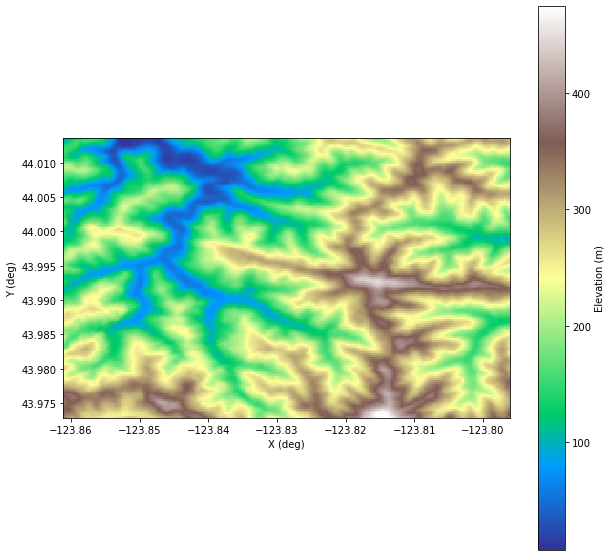

In [5]:
topo = Topography(
    dem_type="SRTMGL1",
    api_key = '1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
# Read DEM as Lanlab grid
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
#Show dem
plt.figure()
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
imshow_grid(grid_geog, 'topographic__elevation',cmap =cmap,
            grid_units=("deg", "deg"),colorbar_label="Elevation (m)")
plt.show()

30.0


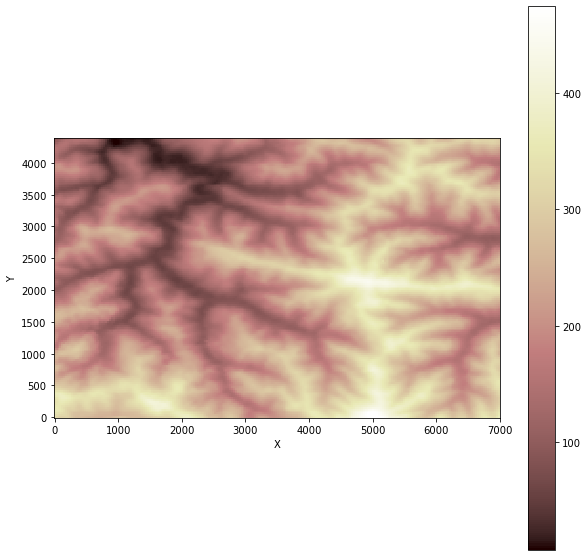

In [6]:
grid = RasterModelGrid((grid_geog.number_of_node_rows,grid_geog.number_of_node_columns),30)
grid.add_field('topographic__elevation',elev, at = 'node')
imshow_grid(grid,'topographic__elevation')
dx=np.diff(grid.x_of_node)[0]
print(dx)

In [7]:
# Saving outputs
printit = True        # be verbose with printing output our not?
save_dir = './simul/' # directory in which to save outputs
# if save directory does not exist and you are to save, make save_dir.
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
dt_sp = 1                   # timestep in years
runtime_sp = 20             # length of the simulation in years
ndt_sp = runtime_sp//dt_sp  # number of timesteps
U_sp = 0.0001                # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp=0.00001            # erodibility coefficient
m_sp=0.5                # Drainage area exponent
n_sp=1                  # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = dt_sp*15    # time it takes the erodibility perturbutions to decay

# Burner
R_fire_mean = len(grid.x_of_node)*dx/500    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1/(2*dt_sp)          # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5*K_sed0           # The increase in sediment erodibility due to fire
K_sp=0.00001          # erodibility coefficient
m_sp=0.5              # Drainage area exponent
n_sp=1                # Slope exponent

fr = FlowAccumulator(grid, flow_director='D8')
df = DepressionFinderAndRouter(grid)

In [8]:
#Add soil to the drainage network (for SPACE)
_ = grid.add_zeros('soil__depth', at='node', dtype=float) 
grid.at_node['soil__depth'] += 0.5
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

In [9]:
K_sed = np.ones(grid.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    grid,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp = n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br)

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt_sp)

In [10]:
start_time = time.time() # for the purposes of tracking the runtime of the simulation loop
for it in range(ndt_sp): # iterate through timesteps
    fr.run_one_step()           # accumulate the flow
    df.map_depressions()        # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt_sp)   # step the transport model
    es.stepper(ha,dt=dt_sp)     # decay the erodibility back toward baseline from the former timestep
    burner.fire(ha,grid,it*dt_sp)          # light any fires (increase erodibility)
    grid.at_node['bedrock__elevation'][grid.core_nodes] += U_sp*dt_sp # incorporate uplift
    grid.at_node['K-sed'] = K_sed
    if (it*dt_sp % 5 == 0) and printit: # if a decade has gone by, then print
        clear_output(wait=True) # jupyter functionality to print over previous output
        # let us kno how long it has been running
        # here the simulation output is saved.
        filename = save_dir + 'simul_%05d.nc'%it # name of file to save the elevation grid
        filename_npy = save_dir + 'simul_%05d'%it # name of file to save the erodibility matrix
        write_netcdf(filename, 
                     grid, 
                     format="NETCDF3_64BIT", # save the grid as a netcdf file
                    ) 
        np.save(filename_npy, K_sed) # the erodibility matrix is saved as a .npy file.
        print("--", it*dt_sp, "years simulated -- %s seconds runtime --" % round((time.time() - start_time), 1))

-- 15 years simulated -- 143.9 seconds runtime --
fire at (3930.0,1890.0) of area 0.0 square km.
fire at (1860.0,3090.0) of area 0.03 square km.


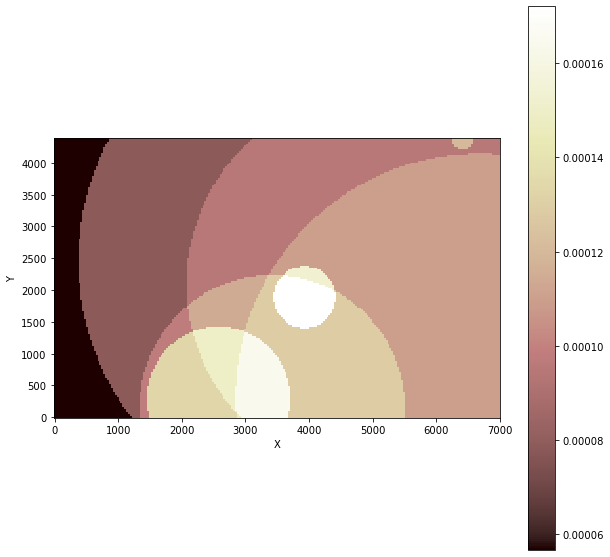

In [11]:
imshow_grid(grid,'K-sed')

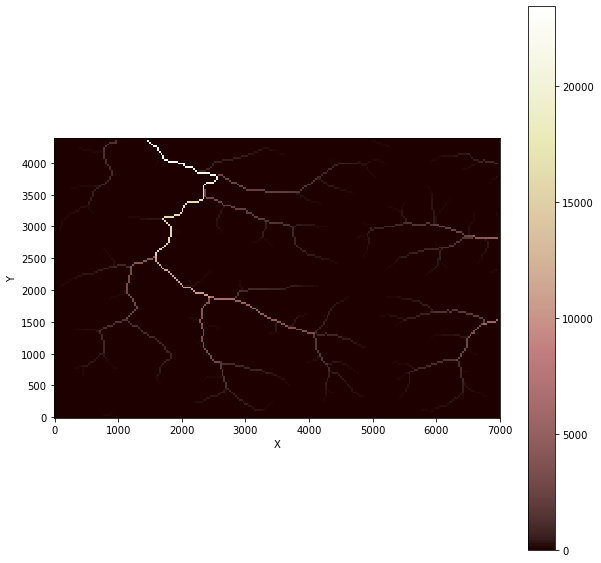

In [12]:
imshow_grid(grid,'sediment__flux')

Text(0.5, 1.0, 'Fire magnitudes through time')

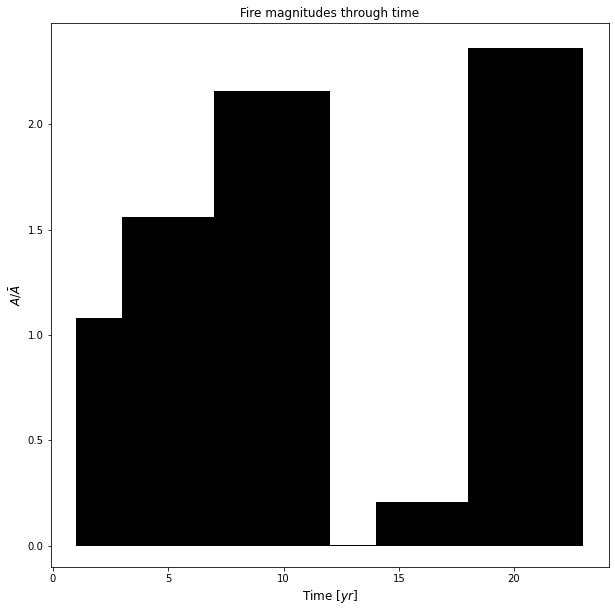

In [13]:
plt.bar(burner.fireTimes,burner.fireSizes/np.mean(burner.fireSizes), width=5, align='edge', lw=2, color='black')
plt.xlabel("Time [$yr$]",fontsize=12)
plt.ylabel(r"$A/\bar{A}$",fontsize=12)
plt.ylim(-0.1)
plt.title('Fire magnitudes through time',fontsize=12)

In [ ]:
flux_save = base+'flux_imgs/'
if not os.path.isdir(flux_save):
    os.mkdir(flux_save)

qmean=0
qstd =0
n=4
o = []
for i in range(n):
    if i<n:
        f1,f2=ks_files[i],grid_files[i]
        f2=base+f2
        grid = read_netcdf(f2)
        q = grid.at_node['sediment__flux'].reshape(grid.shape)
        o.append(q)
o = np.array(o)
        
qmean = np.median(o,axis=0)
qvar = np.var(o) # notice this is not local.


i = 0
for f1,f2 in zip(ks_files,grid_files):
    f1p=base+f1
    f2=base+f2
    K_sed = np.load(f1p)
    grid = read_netcdf(f2)
    fluxyplot(grid, K_sed, K_sed_boost, K_sed0, qmean, qvar)
    
    # maintain the background
    r = 0.0005 # learning rate
    q = grid.at_node['sediment__flux'].reshape(grid.shape) # get the flux from the grid
    qmean = r*q + (1-r)*qmean # here we maintain the background mean using the departure from the mean.
    qvar = r*np.abs(q-qmean).mean()**2 + (1-r)*qvar # similarly for the variance
    plt.savefig(flux_save+'file_%05d.png'%i)
    
    i+=1 # update the index to modify the filename of the saving
    #clear_output(wait=True)
    plt.clf()


In [ ]:
print(grid.at_node['sediment__flux'].reshape(grid.shape),'*')

In [ ]:
print((grid, 'topographic__elevation'))

In [16]:
flow_metric = "D8"
flow_router = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)

# We add some constraints on the boundaries of the DEM / outlet and watershed TODO: CLARIFY
# grid.set_watershed_boundary_condition_outlet_id(
#     0, grid.at_node['topographic__elevation'], -9999.0
# )
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True, 
    left_is_closed=True,
    right_is_closed=True, 
    top_is_closed=True
)

# We run once the router and display the results
flow_router.run_one_step()

In [17]:
ls = BedrockLandslider(
    grid, 
    angle_int_frict=0.5, #84, #have 40 degrees changed to %
    landslides_return_time=1e2, #changed from default of 1e3
    cohesion_eff=1e3) #reduced from 1e3 - just taking a guess

# angle_int_frict in m/m (tangent and not degrees)
# landslides_return_time = 1 -> probability of sliding 100%
# cohesion_eff: Effective cohesion of material [m L^-1 T^-2].

np.random.seed(seed=5000) # stochastic sampling to trigger landslides
ls.run_one_step(dt=timestep)

# Show Landslide Erosion (Red/yellow) and deposition (green/blue) draped over the shaded topographic relief
# my_landslide_plot(grid)

RuntimeError: The sum of bedrock elevation and topographic elevation should be equal

In [21]:
print(grid,'topographic__elevation')

<xarray.Dataset>
Dimensions:         (node: 34398, link: 68415, Two: 2, patch: 34018,
                     max_patch_links: 4, cell: 33640, face: 67657)
Coordinates:
  * node            (node) int64 0 1 2 3 4 5 ... 34393 34394 34395 34396 34397
Dimensions without coordinates: link, Two, patch, max_patch_links, cell, face
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 ... 4.38e+03 4.38e+03 4.38e+03
    x_of_node       (node) float64 0.0 30.0 60.0 ... 6.93e+03 6.96e+03 6.99e+03
    nodes_at_link   (link, Two) int64 0 1 1 2 2 ... 34395 34396 34396 34397
    links_at_patch  (patch, max_patch_links) int64 234 467 233 ... 68180 67947
    node_at_cell    (cell) int64 235 236 237 238 239 ... 34159 34160 34161 34162
    nodes_at_face   (face, Two) int64 1 235 2 236 3 ... 34161 34395 34162 34396 topographic__elevation


In [22]:
print(grid,'bedrock__elevation')

<xarray.Dataset>
Dimensions:         (node: 34398, link: 68415, Two: 2, patch: 34018,
                     max_patch_links: 4, cell: 33640, face: 67657)
Coordinates:
  * node            (node) int64 0 1 2 3 4 5 ... 34393 34394 34395 34396 34397
Dimensions without coordinates: link, Two, patch, max_patch_links, cell, face
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 ... 4.38e+03 4.38e+03 4.38e+03
    x_of_node       (node) float64 0.0 30.0 60.0 ... 6.93e+03 6.96e+03 6.99e+03
    nodes_at_link   (link, Two) int64 0 1 1 2 2 ... 34395 34396 34396 34397
    links_at_patch  (patch, max_patch_links) int64 234 467 233 ... 68180 67947
    node_at_cell    (cell) int64 235 236 237 238 239 ... 34159 34160 34161 34162
    nodes_at_face   (face, Two) int64 1 235 2 236 3 ... 34161 34395 34162 34396 bedrock__elevation
